In [ ]:
 #clone YOLOv5
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12270, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 12270 (delta 5), reused 9 (delta 1), pack-reused 12250
Receiving objects: 100% (12270/12270), 12.02 MiB | 27.23 MiB/s, done.
Resolving deltas: 100% (8491/8491), done.


In [ ]:
#Intalacion de la paqueteria necesaria
!pip install -r yolov5/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 596 kB 9.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

In [ ]:
#Extraccion de nuestro dataset desde google drive
!wget --no-check-certificate --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1C9tMDVt95HjEiHKR3MwRKtzglENyayjE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1C9tMDVt95HjEiHKR3MwRKtzglENyayjE" -O data.zip && rm -rf /tmp/cookies.txt

--2022-06-22 17:48:04--  https://docs.google.com/uc?export=download&confirm=t&id=1C9tMDVt95HjEiHKR3MwRKtzglENyayjE
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.102, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ld5v5ssb3i8b54bp11spu0utehj98u0r/1655920050000/06942482547493834900/*/1C9tMDVt95HjEiHKR3MwRKtzglENyayjE?e=download [following]
--2022-06-22 17:48:04--  https://doc-0k-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ld5v5ssb3i8b54bp11spu0utehj98u0r/1655920050000/06942482547493834900/*/1C9tMDVt95HjEiHKR3MwRKtzglENyayjE?e=download
Resolving doc-0k-2k-docs.googleusercontent.com (doc-0k-2k-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-2k-docs.googleusercontent.com (doc-0k-2k

In [ ]:
#Desempacar dataset
!unzip data.zip
!rm -r data.zip

Archive:  data.zip
   creating: Dataset_Alfabeto/
   creating: Dataset_Alfabeto/anotations/
  inflating: Dataset_Alfabeto/anotations/Alfabeto_0.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_1.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_10.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_100.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_101.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_102.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_103.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_104.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_105.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_106.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_107.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_108.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_109.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_11.xml  
  inflating: Dataset_Alfabeto/anotations/Alfabeto_110.xml  
  inflating: D

In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()

    # Initialise the info dict
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name
        if elem.tag == "filename":
            info_dict['filename'] = elem.text

        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))

            info_dict['image_size'] = tuple(image_size)

        # Get details of the bounding box
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text

                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)
            info_dict['bboxes'].append(bbox)

    return info_dict

In [ ]:
#Ejemplo de uso
extract_info_from_xml("Dataset_Alfabeto/anotations/Alfabeto_0.xml")

{'bboxes': [{'class': 'alpha',
   'xmax': 190,
   'xmin': 37,
   'ymax': 121,
   'ymin': 49},
  {'class': 'alpha', 'xmax': 370, 'xmin': 245, 'ymax': 132, 'ymin': 38},
  {'class': 'alpha', 'xmax': 576, 'xmin': 467, 'ymax': 124, 'ymin': 45},
  {'class': 'alpha', 'xmax': 483, 'xmin': 345, 'ymax': 850, 'ymin': 778},
  {'class': 'alpha', 'xmax': 217, 'xmin': 75, 'ymax': 876, 'ymin': 794},
  {'class': 'beta', 'xmax': 743, 'xmin': 686, 'ymax': 137, 'ymin': 50},
  {'class': 'beta', 'xmax': 136, 'xmin': 76, 'ymax': 376, 'ymin': 273},
  {'class': 'beta', 'xmax': 309, 'xmin': 241, 'ymax': 382, 'ymin': 263},
  {'class': 'beta', 'xmax': 485, 'xmin': 407, 'ymax': 399, 'ymin': 271},
  {'class': 'beta', 'xmax': 679, 'xmin': 606, 'ymax': 642, 'ymin': 518},
  {'class': 'gamma', 'xmax': 109, 'xmin': 25, 'ymax': 657, 'ymin': 541},
  {'class': 'gamma', 'xmax': 312, 'xmin': 216, 'ymax': 653, 'ymin': 509},
  {'class': 'gamma', 'xmax': 507, 'xmin': 412, 'ymax': 651, 'ymin': 525},
  {'class': 'gamma', 'xmax': 

In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"alpha": 0,
                           "beta": 1,
                           "gamma": 2,
                           "delta": 3,
                           "epsilon": 4,
                           "zeta": 5,
                           "eta": 6,
                           "theta": 7,
                           "iota": 8,
                           "kappa": 9,
                           "lambda":10,
                            "mu":11,
                            "nu":12,
                            "xi":13,
                            "omicron":14,
                            "pi":15,
                            "rho":16,
                            "sigma":17,
                            "tau":18,
                            "upsilon":19,
                            "phi":20,
                            "chi":21,
                            "psi":22,
                            "omega":23
                            }

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    # For each bounding box

    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())

            #Manejo de errores por mal etiquetado
            if b["class"]=="alfa" or b["class"]=="alfha": # or b["class"]=="t t-shirt":
               class_id = class_name_to_id_mapping['alpha']
            elif b["class"]=="opsilon" or b["class"]=="upsilion":
               class_id = class_name_to_id_mapping["upsilon"]
            elif b["class"]=="fi":
               class_id = class_name_to_id_mapping["phi"]
            elif b["class"]=="ji":
               class_id = class_name_to_id_mapping["chi"]
            elif b["class"]=="lota":
              class_id = class_name_to_id_mapping["iota"]
            elif b["class"]=="teta":
              class_id = class_name_to_id_mapping["theta"]
            elif b["class"]=="ro":
              class_id = class_name_to_id_mapping["rho"]
            elif b["class"]=="tao":
              class_id = class_name_to_id_mapping["tau"]
            elif b["class"]=="epsilion":
              class_id = class_name_to_id_mapping["epsilon"]
            elif b["class"]=="gama":
              class_id = class_name_to_id_mapping["gamma"]
            elif b["class"]=="kapa":
              class_id = class_name_to_id_mapping['kappa']
            elif b["class"]=="lamba":
              class_id = class_name_to_id_mapping['lambda']
            elif b["class"]=="psii":
              class_id = class_name_to_id_mapping['psi']
            else:
              print(b["class"])
              print(info_dict['filename'])

        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]
        b_center_x /= image_w
        b_center_y /= image_h
        b_width    /= image_w
        b_height   /= image_h

        #Write the bbox details to the file
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))

    # Name of the file which we have to save
    save_file_name = os.path.join("labels", info_dict["filename"][:info_dict["filename"].rfind(".")]+".txt")

    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
#Crear la carpeta donde se almacenaran los labelling formato yolo
%cd Dataset_Alfabeto/
!mkdir labels

/content/Dataset_Alfabeto


In [ ]:
# Get the annotations
annotations = [os.path.join('anotations', x) for x in os.listdir('anotations') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)
annotations = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

  0%|          | 0/239 [00:00<?, ?it/s]

Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dic

100%|██████████| 239/239 [00:00<00:00, 1303.15it/s]

dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'])
Invalid Class. Must be one from  dict_keys(['alpha', 'beta', 'gamma',


Alfabeto_236.jpeg


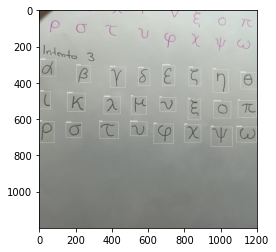

In [ ]:
#Chequeo random de la conversion
random.seed()

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size

    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h

    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))

        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])

    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file
annotation_file = random.choice(annotations)
print()
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
anotacion_fila = annotation_file[annotation_file.find("/")+1:annotation_file.rfind(".")]
for dirpath, dirname, filename in os.walk("images"):
  for name in filename:
    if anotacion_fila == name[:name.rfind(".")]:
      image_file = os.path.join(dirpath, name)
      print(name)
      break

assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Read images and annotations
images = [os.path.join('images', x) for x in os.listdir('images')]
annotations = [os.path.join('labels', x) for x in os.listdir('labels') if x[-3:] == "txt"]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

In [ ]:
#Carpetas para guardar las imagenes/etiquetas de entrenamiento, testeo y validacion
!mkdir images/train images/val images/test labels/train labels/val labels/test

In [ ]:
#Utility function to move images
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, 'images/train')
move_files_to_folder(val_images, 'images/val/')
move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, 'labels/train/')
move_files_to_folder(val_annotations, 'labels/val/')
move_files_to_folder(test_annotations, 'labels/test/')

In [ ]:
#Se obtiene desde el drive el archivo yaml de configuracion
%cd /content/yolov5
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xBnevEqm0wWToD21XPH9sj3663beHJEF' -O data/Dataset_Alfabeto.yaml

/content/yolov5
--2022-06-22 17:48:08--  https://docs.google.com/uc?export=download&id=1xBnevEqm0wWToD21XPH9sj3663beHJEF
Resolving docs.google.com (docs.google.com)... 74.125.195.138, 74.125.195.102, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6ps9cpr04hpgu2fpl0pm1rqeaqeqo67o/1655920050000/06942482547493834900/*/1xBnevEqm0wWToD21XPH9sj3663beHJEF?e=download [following]
--2022-06-22 17:48:09--  https://doc-10-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6ps9cpr04hpgu2fpl0pm1rqeaqeqo67o/1655920050000/06942482547493834900/*/1xBnevEqm0wWToD21XPH9sj3663beHJEF?e=download
Resolving doc-10-2k-docs.googleusercontent.com (doc-10-2k-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-10-2k-docs.googleusercontent.com (doc

In [ ]:
!python train.py --img 640 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 100 --data Dataset_Alfabeto.yaml --weights yolov5s.pt --workers 24 --name datasetAlfabetoT

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=Dataset_Alfabeto.yaml, hyp=hyp.scratch-low.yaml, epochs=100, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=runs/train, name=datasetAlfabetoT, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv

In [ ]:
!python detect.py --source /content/Dataset_Alfabeto/images/test --weights runs/train/datasetAlfabetoT/weights/best.pt --conf 0.25 --name datasetAlfabetoTest

detect: weights=['runs/train/datasetAlfabetoT/weights/best.pt'], source=/content/Dataset_Alfabeto/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=datasetAlfabetoTest, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-259-ga2a1ed2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7074853 parameters, 0 gradients
image 1/24 /content/Dataset_Alfabeto/images/test/Alfabeto_108.jpg: 640x640 Done. (0.013s)
image 2/24 /content/Dataset_Alfabeto/images/test/Alfabeto_115.jpg: 640x640 Done. (0.013s)
image 3/24 /content/Dataset_Alfabeto/images/test/Alfabeto_124.jpg: 640x640 Done. (0.013s)
image 4/24 /content/Dataset_Alfabeto/images/test/Alfab